In [31]:
import shutil
import torch
import os

import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import albumentations as A
import mediapipe as mp
import pandas as pd
import numpy as np

from albumentations.pytorch.transforms import ToTensorV2
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import DatasetFolder
from tqdm import tqdm; tqdm.pandas();

In [32]:
# Устройство для обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

Current device: cuda


# Настройка параметров

In [33]:
# Директории с файлами
DATASET_DIR = './train_landmark_files'
CLASSES_DIR = './Dataset'

# Параметры загрузчиков
BACTH_SIZE  = 1
NUM_WORKERS = 0
PIN_MEMORY  = True

# Параметры оптимизатора
WEIGHT_DECAY  = 5e-5
LEARNING_RATE = 5e-3

MEAN = [0.3395, 0.3431, 0.3020]
STD  = [0.3908, 0.3897, 0.3542]

# Параметры планировщика
FACTOR    = 0.1
PATIENCE  = 10
THRESHOLD = 1e-4

# Параметры модели
ENCODER         = 'resnet50'
ENCODER_WEIGHTS = None

# Параметры обучения
NUM_EPOCHS = 30

# Параметры датасета
ORIGINAL_SIZE = 1500
PADED_SIZE    = 1536
PATCH_SIZE    = 256 
VALID_PART = 0.1
TEST_PART  = 0.1

# Настройка аугментаций

In [34]:
train_transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit = 0.1, contrast_limit = 0.1, p = 0.5),
        A.HorizontalFlip(p = 0.5),
        A.PadIfNeeded(PADED_SIZE, PADED_SIZE, border_mode = 0),
        A.Normalize(mean = MEAN, std = STD),        
        ToTensorV2()])

val_test_transform = A.Compose([
    A.PadIfNeeded(PADED_SIZE, PADED_SIZE, border_mode = 0),
    A.Normalize(mean = MEAN, std = STD),
    ToTensorV2()])

# Распределение классов в датасете

In [35]:
df = pd.read_csv('./train.csv')
df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


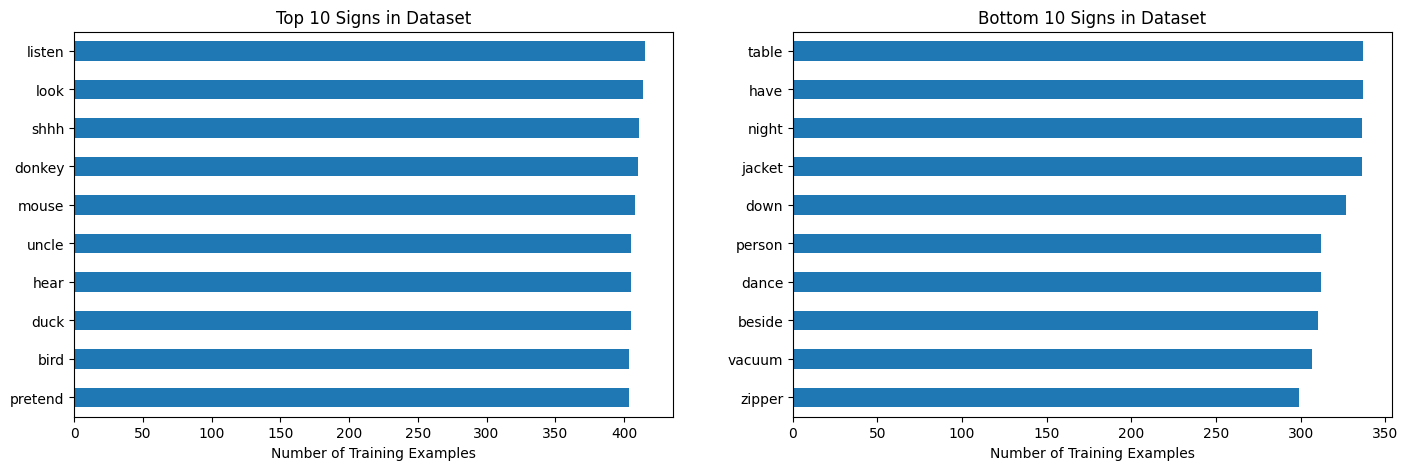

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17, 5))

df['sign'].value_counts().head(10).sort_values(ascending = True).plot(
    kind = "barh", ax = ax1, title = 'Top 10 Signs in Dataset'
)

df['sign'].value_counts().tail(10).sort_values(ascending = True).plot(
    kind = "barh", ax = ax2, title = 'Bottom 10 Signs in Dataset'
)

ax1.set_xlabel('Number of Training Examples')
ax2.set_xlabel('Number of Training Examples')

plt.show()

# Сортировка файлов по классам

In [37]:
def path_handle(path, sign):

    if not os.path.exists(os.path.join(CLASSES_DIR, sign)):        
        os.mkdir(os.path.join(CLASSES_DIR, sign))

    shutil.move(path, os.path.join(CLASSES_DIR, sign))

In [38]:
if not os.path.exists(CLASSES_DIR):
    os.mkdir(CLASSES_DIR)

    [path_handle(path, sign) for path, _, _, sign in zip(df['path'], df['participant_id'], df['sequence_id'], df['sign'])]

# Пример тренировочных данных

In [39]:
EXAMPLE_DIR = './Dataset/after/1044729798.parquet'

In [40]:
df = pq.read_table(EXAMPLE_DIR).to_pandas()
df.head()

,frame,row_id,type,landmark_index,x,y,z
0,17,17-face-0,face,0,0.503836,0.500633,-0.043933
1,17,17-face-1,face,1,0.497457,0.471682,-0.064423
2,17,17-face-2,face,2,0.500418,0.482863,-0.038524
3,17,17-face-3,face,3,0.487654,0.446823,-0.039804
4,17,17-face-4,face,4,0.496760,0.463060,-0.066302


In [41]:
df = pq.read_table(EXAMPLE_DIR).to_pandas().dropna()
df = df.drop(columns = ['row_id'], axis = 1)
df = pd.get_dummies(df, columns = ['type'], prefix = '', prefix_sep = '')
df.head()

,frame,landmark_index,x,y,z,face,pose,right_hand
0,17,0,0.503836,0.500633,-0.043933,1,0,0
1,17,1,0.497457,0.471682,-0.064423,1,0,0
2,17,2,0.500418,0.482863,-0.038524,1,0,0
3,17,3,0.487654,0.446823,-0.039804,1,0,0
4,17,4,0.496760,0.463060,-0.066302,1,0,0


# Разделение датасета

In [42]:
def preprocess_df(path):

    df = pq.read_table(path).to_pandas().dropna()
    df = df.drop(columns = ['row_id'], axis = 1)
    df = pd.get_dummies(df, columns = ['type'], prefix = '', prefix_sep = '')

    return df.to_numpy()

In [43]:
dataset = DatasetFolder(
    CLASSES_DIR, loader = lambda path: preprocess_df(path), is_valid_file = lambda _: True)

n_val   = int(len(dataset) * VALID_PART)
n_test  = int(len(dataset) * TEST_PART)
n_train = len(dataset) - n_val - n_test

train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train, n_val, n_test])

In [44]:
idx_to_class = {val: key for key, val in dataset.class_to_idx.items()}

# Создание загрузчиков

In [45]:
train_loader = DataLoader(train_dataset, batch_size = BACTH_SIZE, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)
val_loader   = DataLoader(val_dataset, batch_size = BACTH_SIZE, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)
test_loader  = DataLoader(test_dataset, batch_size = BACTH_SIZE, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)

# Визуализация данных

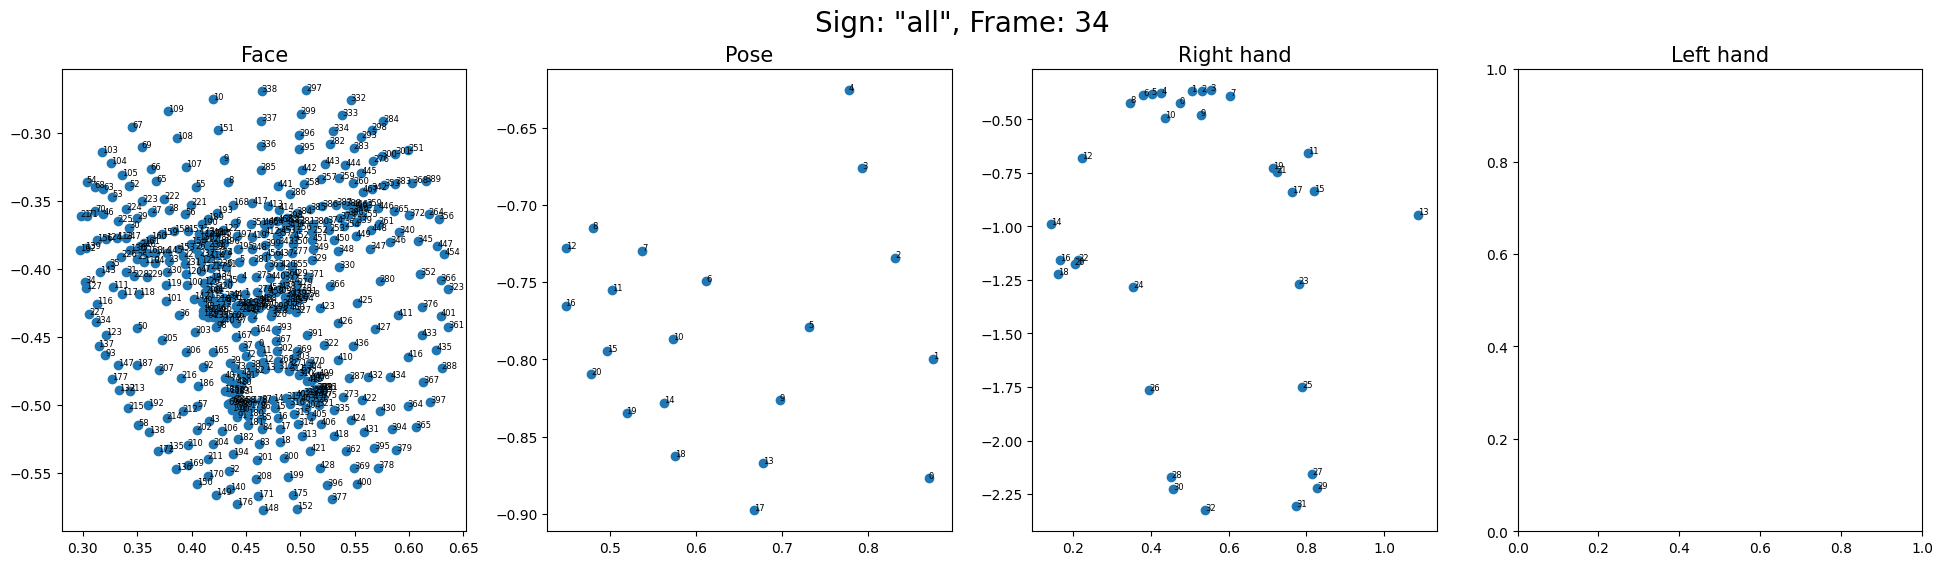

In [55]:
def show_frame(frame, label, frame_num):
    
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize = (24, 6))

    face_lm  = frame[frame[:, 5] == 1]
    pose_lm  = frame[frame[:, 6] == 1]
    right_lm = frame[frame[:, 7] == 1]

    ax1.set_title('Face', fontsize = 15)
    ax2.set_title('Pose', fontsize = 15)
    ax3.set_title('Right hand', fontsize = 15)
    ax4.set_title('Left hand', fontsize = 15)

    ax1.scatter(face_lm[:, 2], -face_lm[:, 3])
    ax2.scatter(pose_lm[:, 2], -pose_lm[:, 3])
    ax3.scatter(right_lm[:, 2], -right_lm[:, 3])

    for _, lm_id, x, y, _, _, _, _ in face_lm:
        ax1.text(x, -y, int(lm_id), fontsize = 6)

    for _, lm_id, x, y, _, _, _, _ in pose_lm:
        ax2.text(x, -y, int(lm_id), fontsize = 6)

    for _, lm_id, x, y, _, _, _, _ in right_lm:
        ax3.text(x, -y, int(lm_id), fontsize = 6)

    fig.suptitle(f'Sign: "{label}", Frame: {frame_num}', fontsize = 20)
    plt.show()

data, label = train_dataset[0]
data = data[data[:, 0] == data[0, 0]]

show_frame(data, idx_to_class[label], int(data[0, 0]))